# Imports and initial basic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import ast

#Import functions from `spectrum_helper_calcs.py`
import sys
sys.path.insert(0, '../')
from spectrum_helper_calcs import *

In [2]:
raw_data_directory = 'ave_raw_data'
processed_dark_data_directory = 'processed_data'
processed_data_directory = 'processed_data'

start_index = 50
end_index = 998

params_for_dark_data = { 'start_index' : start_index,
                         'end_index' : end_index,
                       }

# Function definitions

In [3]:
def makename(datadirectory,filename):
    return os.path.join(datadirectory,filename)

def process_and_save_dark_data(raw_data_directory, processed_data_directory, params_for_dark_data):
    '''
    Convert average dark data file from two rows to two columns and put in correct directory.
    
    Arguments:
        raw_data_directory - path to raw data directory
        processed_data_directory - path to directory in which to save processed data
        params_for_dark_data - dict with start_index, end_index (both mandatory), and any other desired parameters
            start_index, end_index - range of data to use
    
    Returns:
        Name and relative path of processed dark data file
    '''
    dark_file = get_list_of_data_files(raw_data_directory, 'dark')[0]
    temp_dark = np.loadtxt(makename(raw_data_directory, dark_file), delimiter=',', dtype=float)
    start_index = params_for_dark_data['start_index']
    end_index = params_for_dark_data['end_index']
    ave_dark = np.zeros(shape=(end_index-start_index, 2))
    ave_dark[:,0] = temp_dark[0,start_index:end_index]
    ave_dark[:,1] = temp_dark[1,start_index:end_index]
    processed_dark_data_file = 'dark_2015-06-27.csv'
    params_for_dark_data['dark_data_file'] = processed_dark_data_file
    temp_name = makename(processed_data_directory, processed_dark_data_file)
    np.savetxt(temp_name, ave_dark, delimiter=',', header=str(params_for_dark_data))
    return temp_name

def process_and_save_spectrum_data(raw_data_directory, processed_data_directory, dark_data_file):
    '''
    Convert average spectrum data file from two rows to two columns, dark-correct data,
    and put in correct directory.
    
    Arguments:
        raw_data_directory - path to raw data directory
        processed_data_directory - path to directory in which to save processed data
        dark_data_file - dark data file name including path
    
    Returns:
        Name and relative path of processed spectrum data file
    '''
    dark_info, dark_data = get_processed_data_from_file(dark_data_file)
    spectrum_file = get_list_of_data_files(raw_data_directory, 'spectrum')[0]
    temp_spectrum = np.loadtxt(makename(raw_data_directory, spectrum_file), delimiter=',', dtype=float)
    start_index = dark_info['start_index']
    end_index = dark_info['end_index']
    ave_spectrum = np.zeros(shape=(end_index-start_index, 2))
    ave_spectrum[:,0] = temp_spectrum[0,start_index:end_index]
    ave_spectrum[:,1] = temp_spectrum[1,start_index:end_index]
    ave_spectrum[:,1] -= dark_data[:,1]
    dark_info['max_value'] = np.max(ave_spectrum[:,1])
    ave_spectrum[:,1] /= dark_info['max_value']  # Normalize
    processed_spectrum_data_file = 'asiga_2015-06-27.csv'
    temp_name = makename(processed_data_directory, processed_spectrum_data_file)
    np.savetxt(temp_name, ave_spectrum, delimiter=',', header=str(dark_info))
    return temp_name

def get_list_of_data_files(datadirectory, datatype):
    '''
    Get list of raw data files (*.csv) in specified directory with specified type (dark or spectrum).
    
    Arguments:
        data_directory - directory in which raw data files reside
        data_type - dark data if data_type='dark' or 
                    spectrum data if data_type='spectrum'
    
    Returns:
        List of file names
    '''
    list_of_data_files = []
    for f in os.listdir(datadirectory):
        if f.endswith('csv'):
            if datatype == 'dark':
                if f.startswith('dark'):
                    list_of_data_files.append(f)
            elif datatype == 'spectrum':
                if not f.startswith('dark'):
                    list_of_data_files.append(f)
            else:
                raise ValueError('datatype argument must be "dark" or "spectrum". Instead it is' + datatype)
    return list_of_data_files

def get_processed_data_from_file(path_to_file):
    '''
    Retrieve processed spectrum data from specified file which can optionally have
    one comment line as the first line in the file.
    
    Arguments:
        path_to_file - relative path (including name) to processed data file
    
    Returns:
        header string - None if there is no header string
        numpy array with data. Columns are wavelength, spectrum, and (optionally) standard deviation
    '''
    # Read header line
    with open(path_to_file) as f:
        line = f.readline()
        li=line.strip()
        if li.startswith('#'):
            header = ast.literal_eval(li[2:])  # strip '# ' and convert to dict
        else:
            header = None
    # Read the rest of the file
    data = np.loadtxt(path_to_file, delimiter=',', dtype=float)
    return header, data

# Process dark data and save to file

In [4]:
dark_data_file_name = process_and_save_dark_data(raw_data_directory, 
                                                 processed_dark_data_directory, params_for_dark_data)
print(dark_data_file_name)

processed_data/dark_2015-06-27.csv


# Process spectrum data and save to file

In [5]:
spectrum_data_file_name = process_and_save_spectrum_data(raw_data_directory, 
                                                         processed_dark_data_directory,
                                                         dark_data_file_name)
print(spectrum_data_file_name)

processed_data/asiga_2015-06-27.csv


# Analyze and plot spectrum

In [6]:
# Load data
dark_info, dark_data = get_processed_data_from_file(dark_data_file_name)
spectrum_info, spectrum_data = get_processed_data_from_file(spectrum_data_file_name)

In [7]:
peak_Index = find_index_of_max(spectrum_data[:,1])
FWHM_indices = find_FWHM_indices(spectrum_data[:,1])
FWHM_nm = calc_FWHM_nm(spectrum_data)
print('             Index of emission peak:', peak_Index)
print('        Wavelength of emission peak:', spectrum_data[peak_Index,0])
print('Value at emission peak (normalized):', spectrum_data[peak_Index,1])
print('                          FWHM (nm):', FWHM_nm)

             Index of emission peak: 227
        Wavelength of emission peak: 411.759144835
Value at emission peak (normalized): 1.0
                          FWHM (nm): 26.7831967597


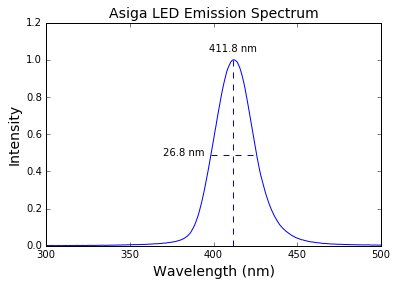

In [10]:
fig, ax = plt.subplots()

ax.plot(spectrum_data[:,0], spectrum_data[:,1])
ax.plot([spectrum_data[peak_Index,0], spectrum_data[peak_Index,0]], [0, spectrum_data[peak_Index,1]], 'b--')
ax.text(spectrum_data[peak_Index,0], 1.09, '{:5.1f} nm'.format(spectrum_data[peak_Index,0]),
        verticalalignment='top', horizontalalignment='center',
        transform=ax.transData)
ax.plot([spectrum_data[FWHM_indices[0],0], spectrum_data[FWHM_indices[1],0]], 
        [spectrum_data[FWHM_indices[0],1], spectrum_data[FWHM_indices[0],1]], 'b--')
ax.text(spectrum_data[FWHM_indices[0],0]-0.6*FWHM_nm, 0.5, '{:4.1f} nm'.format(FWHM_nm),
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transData)

ax.set_xlim(300, 500)
ax.set_ylim(0, 1.2)
ax.set_xlabel('Wavelength (nm)', fontsize='14')
ax.set_ylabel('Intensity', fontsize='14')
ax.set_title('Asiga LED Emission Spectrum', fontsize='14')
#plt.savefig('asiga_spectrum.png')